In [1]:
push!(LOAD_PATH, pwd()*"/..")
import_path = "/Users/julian/Harvard/research/nowak/indirect_rec/src"
push!(LOAD_PATH, import_path)
using LightGraphs, Epidemics, GraphGeneration,IM
using NLsolve
using PyPlot, Distributions
using DegreeDistribution
using StatsBase
using GraphCreation
using GraphClustering
using DataAnalysis
using TwoLevelGraphs


Use "Graph{P}(...) where P" instead.


In [12]:
N = 400
k = 14
C = 0.5
d = Binomial(k,1) 

c_r = 0.3
y_n = 0.1

n_n = Int(N*y_n)#y_n*N
beta = get_beta(N,c_r,n_n)#4.0/(c_r*n_n)
alpha = get_alpha(N,c_r,n_n)#(N*beta)/n_n

alpha,beta = 0.4,0.04
# beta = 0.0
# alpha = 10


println(alpha," ", beta)
im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
fixation_threshold = (N-2)/N
carry_by_node_information = false
graph_model = true
in_parallel = true

#:erdos_renyi,:watts_strogatz,:gamma_fb,:rand_clust

# G = create_graph(N,k,:erdos_renyi,C,deg_distr=d)
# H = create_graph(N,k,:rand_clust,C,deg_distr=d)
K = create_graph(N,k,:watts_strogatz,C,deg_distr=d)
# GC = regular_clustering_graph(N,k,C)
R = LightGraphs.random_regular_graph(N,k)
m = 14 #0.5: m=14,l=9,r=1 $ 0.3: m = 10, l = 7, r = 3
l = 11
r = k -l
t = TwoLevel(Int(ceil(N/m)*m),m,l,r)
# l = 9
# m = 20
# t = TwoLevel(N,m,l,k-r)
println(t.N)
T = generate_regular_two_level_graph(t)
# println(mean(local_clustering_coefficient(G)))
# println(mean(local_clustering_coefficient(H)))
println(mean(local_clustering_coefficient(K)))
println(mean(local_clustering_coefficient(R)))
println(mean(local_clustering_coefficient(T)))
println(get_community_graph_fixation_ratio(t,alpha,beta))
# println(mean(local_clustering_coefficient(GC)))

0.4 0.04
406
0.5027861419626125
0.03222527472527471
0.4954798895685602
0.003583469021304585


# The effect of clustering gets stronger with small $k$ and with large $N$.

It might have something to do with how the pair counts are estimated. For example, why do II pairs sometimes rise while IS pairs go extinct? Sometimes the pair count should be higher than the model suggests (i.e. mis = 0, mii large should give a lot of overlap pairs). How do I avoid impossible counts?

Somehow the algorithm seems to produce to many II pairs for large N


It seems that the clustering theory also predicts transitions to a state where we get emergence of global cascades. Will it hold for larger $k$?

In [16]:
num_trials = 4000
# println(C)
# Profile.clear()
#Profile.print()
fixation_threshold = 0.9
@time yy,pp,edge_counts = GraphClustering.get_p_reach_well_mixed_with_clustering(N,k,C,alpha,beta,num_trials,fixation_threshold);    
@time yyrc,pprc,edge_countsrc = GraphClustering.get_p_reach_well_mixed_with_clustering(N,k,(k-1)/N,alpha,beta,num_trials,fixation_threshold);    
# println(C)
im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta)
yyr = logspace(log10(1/N),0,500)
@time ppr = P_reach_fast(im,N,1.0/N,yyr,true);

 67.628806 seconds (732.37 M allocations: 12.381 GiB, 13.17% gc time)
 66.236989 seconds (691.41 M allocations: 11.689 GiB, 16.59% gc time)
  0.007976 seconds (206.90 k allocations: 3.840 MiB)


In [17]:
num_trials_local_sim = 4000
# graph_fn = () -> create_graph(N,k,:erdos_renyi,C,deg_distr=d)
graph_fn = () -> K #create_graph(N,k,:watts_strogatz,C,deg_distr=d)
graph_data = C

graph_information = GraphInformation(graph_fn,Graph(),carry_by_node_information,graph_data)

@time runssim = run_epidemics_parallel(num_trials_local_sim,() -> run_epidemic_graph_gillespie(N,im_normal,graph_information,fixation_threshold),in_parallel);
yysim,ppsim = get_p_reach(runssim)
yysim /= N

num_points = 200
@time yytl,pptl,s_eff_two_level = get_p_reach_theory(t,1.0*alpha,1.0*beta,N,true,num_points)


 64.199435 seconds (487.05 M allocations: 13.043 GiB, 7.57% gc time)
  2.330824 seconds (31.39 M allocations: 697.029 MiB, 23.49% gc time)


([0.0025, 0.00257641, 0.00265516, 0.00273632, 0.00281996, 0.00290615, 0.00299498, 0.00308652, 0.00318087, 0.00327809  …  0.762639, 0.785949, 0.809972, 0.83473, 0.860244, 0.886538, 0.913635, 0.941561, 0.970341, 1.0], [1.0, 0.970249, 0.941383, 0.913377, 0.886205, 0.859842, 0.834264, 0.809447, 0.785369, 0.76201  …  0.0350824, 0.0350824, 0.0350824, 0.0350824, 0.0350824, 0.0350824, 0.0350824, 0.0350824, 0.0350824, 0.0350824], TwoLevelGraphs.s_actual)

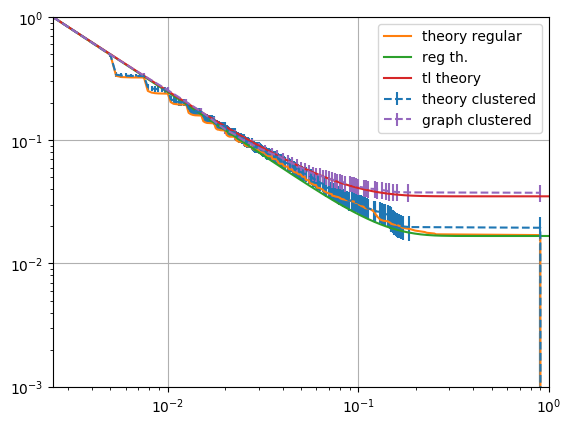

PyObject <matplotlib.legend.Legend object at 0x1464ac9d0>

In [18]:
# loglog(yy/N,pp)
errorbars = 2*(pp.*(1-pp)/num_trials).^0.5
plt[:errorbar](yy,pp,linestyle="--",yerr=errorbars,label="theory clustered")#,label=simulation_labels[i])
# loglog([],[])

loglog(yyrc,pprc,label="theory regular")
loglog(yyr,ppr,label="reg th.")


# errorbars_c = 2*(ppc.*(1-ppc)/runs.num_trials).^0.5
# plt[:errorbar](yyc,ppc,linestyle="--",yerr=errorbars_c,label="odyssey sim")#,label=simulation_labels[i])
# loglog(yyc,ppc)

loglog(yytl,pptl,label="tl theory")

errorbars_sim = 2*(ppsim.*(1-ppsim)/num_trials_local_sim).^0.5
plt[:errorbar](yysim,ppsim,linestyle="--",yerr=errorbars_sim,label="graph clustered")#,label=simulation_labels[i])
# loglog(yysim,ppsim)
xlim([1/N,1])
ylim([1e-3,1])
# ylim([1/num_trials,1])
grid()
legend()

In [71]:
data_dir_path = "../../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"
filenames = split(readstring(`ls $data_dir_path`));
filenames[1:12]
path = data_dir_path*filenames[end-6]
params,yyc,ppc,epidemic_params,k_c,graph_information,graph_type,runs,num_trials_sim = load_p_reach_data(path);
filenames[end-10:end]
epidemic_params.N,k_c,graph_information.data,epidemic_params.alpha,epidemic_params.beta

(10000,10,0.1,0.13333333333333333,0.013333333333333334)

In [268]:
runs.num_trials

10000

In [261]:
function get_expected_clustering(k,N,ki,m)
    ke = k - ki 
    C_i = (ki-1)/(m-2)
    C_e = (N-2*m)*(ke-1)/(N-m)^2 + (m/(N-m))*(ki/(m-1))
    return (ki*(ki-1)*C_i + ke*(ke-1)*C_e )/ (k*(k-1))
end

function get_expected_clustering(t::TwoLevel)
    return get_expected_clustering(t.l + t.r,t.N,t.l,t.m)
end

function g!(x, fvec)
    fvec[1] = get_c_fn(x[1],x[2]) - C
#     fvec[2] = sum((x - round(x)).^2)
end


g! (generic function with 1 method)

In [205]:
N = 24*100
m = 24 #m=14,l=9,r=1
k = 10
l = 9
r = k -l
t1 = TwoLevel(Int(ceil(N/m)*m),m,l,r)
println(get_expected_clustering(t1))
T = generate_regular_two_level_graph(t1)
println(mean(local_clustering_coefficient(T)))

0.29090909090909095
0.267861111111111


In [155]:
using NLsolve

C = 0.5
N = 400
k = 10

get_c_fn(ki,m) = get_expected_clustering(k,N,ki,m)


sol = nlsolve(g!, [k/2,N/2])


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [5.0,200.0]
 * Zero: [10.4766,22.9165]
 * Inf-norm of residuals: 0.000000
 * Iterations: 12
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 13
 * Jacobian Calls (df/dx): 8

In [145]:
solution = round(sol.zero)
ki = Int(solution[1])
m = Int(solution[2])
t1 = TwoLevel(Int(ceil(N/m)*m),m,ki,k-ki)
println(get_expected_clustering(t1))
T = generate_regular_two_level_graph(t1)
println(mean(local_clustering_coefficient(T)))

0.45


LoadError: InterruptException:

In [206]:
using JuMP
using CoinOptServices

function get_optimal_tl_params(N,k,C)

    mod = Model(solver=OsilBonminSolver())
    @variable(mod,ki_v, Int)
    @variable(mod,m_vh, Int)

    @NLobjective(mod,Min,(C - (ki_v*(ki_v-1)*(ki_v-1)/(2*m_vh-2) + (k-ki_v)*((k-ki_v)-1)*((N-2*2*m_vh)*((k-ki_v)-1)/(N-2*m_vh)^2 + (2*m_vh/(N-2*m_vh))*(ki_v/(2*m_vh-1))) )/ (k*(k-1)))^2)    
    @NLconstraint(mod,ki_v <= 2*m_vh-1)
    @NLconstraint(mod,1 <= ki_v <= k-1)
    @NLconstraint(mod,1 <= 2*m_vh <= N/2)
    # @NLconstraint(mod,ki_v*m_v/2 == round(ki_v*m_v/2))

    # Solve problem using MIP solver
    status = solve(mod)

    println("Objective is: ", getobjectivevalue(mod))
    println("Solution is:")
    println("ki = ",getvalue(ki_v))
    println("m = ",2*getvalue(m_vh))


    ki = Int(getvalue(ki_v))
    m = Int(2*getvalue(m_vh) )
    t1 = TwoLevel(Int(ceil(N/m)*m),m,ki,k-ki)
    println(get_expected_clustering(t1))
    T = generate_regular_two_level_graph(t1)
    println(mean(local_clustering_coefficient(T)))
    return t1
end


get_optimal_tl_params (generic function with 1 method)

In [220]:
get_optimal_tl_params(24*100,10,0.1*1.0)



Optimization Services Solver
Main Authors: Horand Gassmann, Jun Ma, and Kipp Martin
Distributed under the Eclipse Public License
OS Version:  2.9.3
Build Date: Oct 24 2016




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Objective is: 6.720655683212513e-8
Solution is:
ki = 7.0
m = 30.0
0.10025924227439237
0.08694444444444427


TwoLevelGraphs.TwoLevel(Number[0,0,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],2400,30,80,0,3,7)

## Plot individual time series

In [57]:
function get_individual_arrays(ecs::Array{EdgeCounts,1})
    len = length(ecs)
    miis = zeros(len)
    miss = zeros(len)
    msss = zeros(len)
    ns = zeros(len)
    for i = 1:len
        miis[i] = ecs[i].mii
        miss[i] = ecs[i].mis
        msss[i] = ecs[i].mss
        ns[i] = GraphClustering.get_num_infecteds(ecs[i])
    end
    return miis,miss,msss,ns
end

function get_z_arrays(ecs::Array{EdgeCounts,1},C,central_infected,attached_infected)
    len = length(ecs)
    z_a_arr = zeros(len)
    z_a_b_arr = zeros(len)
    z_a_b_mean_arr = zeros(len)
    for i = 1:len
        ms = ecs[i]
        if ms.mis > 0
            z_a_arr[i] = get_z_a(ms,central_infected)
            z_a_b_arr[i] = get_z_a_b(ms,central_infected,attached_infected)
            z_a_b_mean_arr[i] = get_z_a_b_mean(C,ms,central_infected,attached_infected)
        end
    end
    return z_a_arr,z_a_b_arr,z_a_b_mean_arr
end

function get_infection_size(ecs::Array{EdgeCounts,1})
    len = length(ecs)
    size_curr = 0
    for i = 1:len
        size_curr += GraphClustering.get_num_infecteds(ecs[i])
    end
    size_curr *= 0.1
    return size_curr
end

function get_max_reach(ecs::Array{EdgeCounts,1})
    max_curr = -1.0
    for i = 1:length(ecs)
        max_curr = max(GraphClustering.get_num_infecteds(ecs[i]),max_curr)
    end
    return max_curr
end
    

get_max_reach (generic function with 1 method)

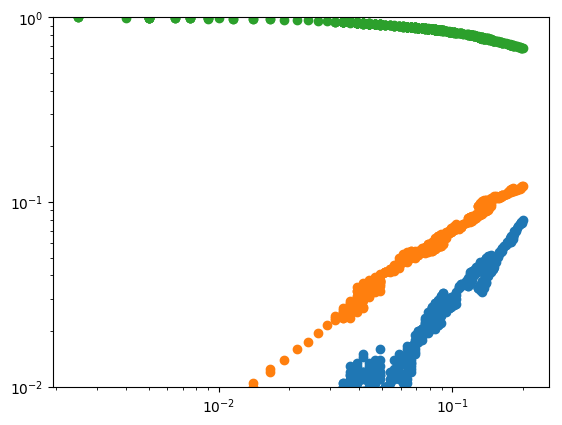

(0.01, 1.0)

In [65]:

loglog([],[])
scatter(ns/GraphClustering.get_N(ms),miis/m)
scatter(ns/GraphClustering.get_N(ms),miss/m)
scatter(ns/GraphClustering.get_N(ms),msss/m)
ylim([1e-2,1])

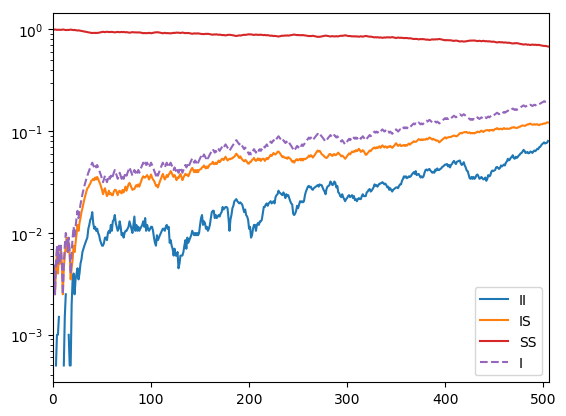

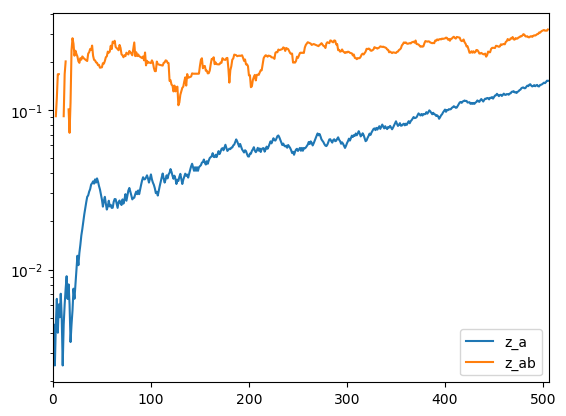

PyObject <matplotlib.legend.Legend object at 0x138d8d490>

In [63]:

idx = 38
C = 0.5
ecs = edge_counts[idx]

xlim_ = length(ecs)#200
ms = ecs[1]
m = ms.m
miis,miss,msss,ns = get_individual_arrays(ecs)
z_a,z_ab,z_abm = get_z_arrays(ecs,C,false,true)
#when attached infected is false, the time series become the same
xlim([0,xlim_])
plot(miis/m,label="II")
plot(miss/m,label="IS")
semilogy([],[])
plot(msss/m,label="SS")

# plot(z_a,label="z_a")
# plot(z_ab,label="z_ab")
# plot(msss+2*miss+miis,label="Tot")
plot(ns/GraphClustering.get_N(ms),"--",label="I")
legend(loc="best")
# ylim([1e-2,2e-2])
# ylim([0.5/m,1.1])
# xlim([8100,8120])
figure()
xlim([0,xlim_])
plot(z_a,label="z_a")
plot(z_ab,label="z_ab")
semilogy([],[])
# plot(z_abm,label="z_abm")
legend()

In [60]:
for i = 1:1000
    if length(edge_counts[i]) > 100
        println("$i: $(get_max_reach(edge_counts[i]))")
#         println("$i: $(length(edge_counts[i]))")
    end
    if edge_counts[i][end-1].mii == 2
        println("here: $i")
    end
#     if (get_max_reach(edge_counts[i])) > 1000
#         println("$i: $(get_max_reach(edge_counts[i]))")
#     end
end

6: 80.0
11: 80.0
here: 12
here: 15
here: 19
here: 25
28: 80.0
38: 80.6
here: 39
41: 80.0
43: 80.6
46: 80.0
here: 47
50: 80.2
57: 80.2
here: 61
65: 12.0
74: 80.0
here: 76
77: 80.0
79: 80.8
80: 80.0
here: 82
here: 85
86: 80.2
87: 80.0
91: 80.2
94: 14.0
95: 80.6
97: 80.0
here: 100
102: 80.0
here: 111
112: 80.0
here: 116
121: 80.2
122: 80.0
124: 80.6
here: 125
126: 80.0
127: 80.0
128: 80.0
here: 129
130: 80.6
131: 80.0
here: 135
138: 80.0
140: 80.0
145: 80.0
147: 80.0
150: 80.2
152: 80.0
155: 80.2
here: 157
160: 80.0
here: 165
170: 80.0
here: 172
174: 80.0
179: 11.6
here: 179
186: 80.0
187: 80.0
189: 80.0
191: 80.0
here: 193
here: 199
here: 207
here: 208
217: 80.0
here: 218
here: 220
224: 14.0
226: 80.0
here: 227
233: 80.0
here: 235
here: 237
239: 80.0
here: 244
245: 80.8
246: 80.0
here: 249
250: 80.0
255: 80.0
257: 80.2
here: 263
266: 80.0
here: 269
277: 80.0
279: 80.0
280: 80.8
281: 80.0
287: 80.0
here: 289
294: 80.4
296: 80.0
298: 80.0
here: 301
303: 80.0
305: 80.2
306: 80.8
here: 307
3

LoadError: [91mBoundsError: attempt to access 400-element Array{Array{GraphClustering.EdgeCounts,1},1} at index [401][39m

## Why do we get steady state behavior?

## Where does the factor of $k$ go?

## Posterior distribution over k

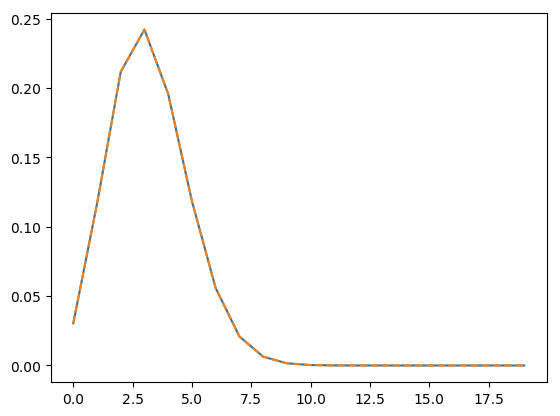

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326409e90>

In [41]:
k = 20
z_a = 0.01
z_ab = 0.8
C = 0.2
bins = collect(0:k-1)
plot(bins,[Clustering.prior_ki(_,k-1,z_a,z_ab,C) for _ in bins])
plot(bins,[Clustering.prior_ki_fast(_,k-1,z_a,z_ab,C) for _ in bins],"--")

In [62]:
alpha,beta = 0.06,0.66
k = 6
N = 400
# n = 50
C = 0.5
ms = EdgeCounts(Int(N*k/2),0,N*k,k)
num_trials = 10000
central_infected = false 
attached_infected = true 
z_a_b_m = get_z_a_b_mean(C,ms,central_infected,attached_infected)


@time kis = [Clustering.draw_k_i(ms,k,C,central_infected,attached_infected)[1] for i = 1:num_trials]
@time kisp = [Clustering.sample_posterior_k_i(C,ms,central_infected,attached_infected,alpha,beta)[1] for i = 1:num_trials]
@time approx = rand(Binomial(k-1,z_a_b_m),num_trials);
ms
z_a = get_z_a(ms,central_infected)
z_ab = get_z_a_b(ms,central_infected,attached_infected)
println("z_a: $(z_a), z_ab: $(z_ab)")
Clustering.get_pair_count(ms,central_infected,attached_infected)
Clustering.get_pair_count_approximation(ms,central_infected,attached_infected)

  0.027556 seconds (133.27 k allocations: 2.636 MB)
  0.051836 seconds (673.27 k allocations: 14.385 MB, 12.57% gc time)
  0.000420 seconds (7 allocations: 78.391 KB)
z_a: 0.5, z_ab: 0.3333333333333333


600.0

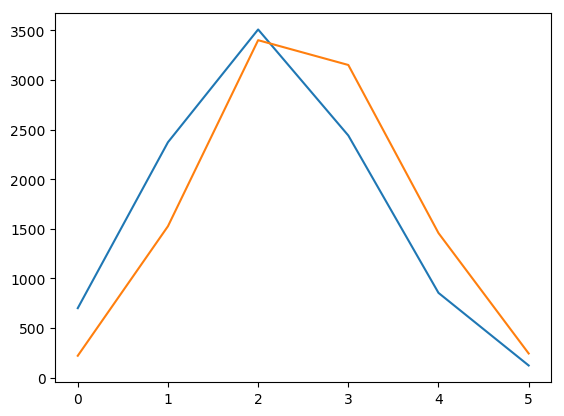

z_a: 0.5, z_ab: 0.3333333333333333


In [56]:
figure()
bins = collect(0:k-1)
# PyPlot.plt[:hist](kis,bins=bins,alpha=0.5,label="prior")
# PyPlot.plt[:hist](kisp,bins=bins,alpha=0.5,label="post")
plot(counts(kis))
plot(counts(kisp))
# plot(counts(approx),"--")
legend()



## Neighborhood community likelihood

In [193]:

N = 400
k = 7
C = 0.62

alpha,beta = 3.0,0.3
# n = 50
C = 1.0
central_infected = true
mis = 50#Int(round(0.5*N*k/2)) #k
mii = Int(round(N*k/2))
ms = EdgeCounts(mii,mis,N*k,k)

GraphClustering.EdgeCounts(1400, 50, 50, 1300, 2800, 7)

In [198]:
pkis_naive = get_p_k_i_naive(C,ms,central_infected)#GraphClustering.binomial_pdf.(ms.k,collect(0:ms.k),get_z_a(ms,central_infected))
println(get_z_a(ms,central_infected))

C = 0.9
pkis = get_p_k_i_global(C,ms,central_infected)
get_mean(pkis)/ms.k, pkis

0.9655172413793104


(0.9778163384122951, [0.0002974, 0.00215596, 0.00651221, 0.010491, 0.00950854, 0.0049057, 0.0274061, 0.938723])

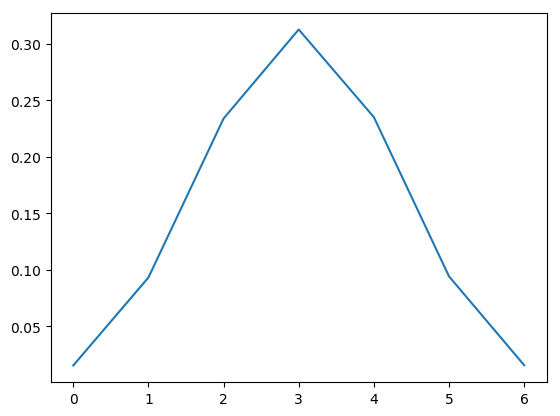

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15335ec50>

In [205]:
plot(GraphClustering.binomial_pdf.(k-1,0:k-1,get_z_a_b_mean(1.0,ms,central_infected,false)))

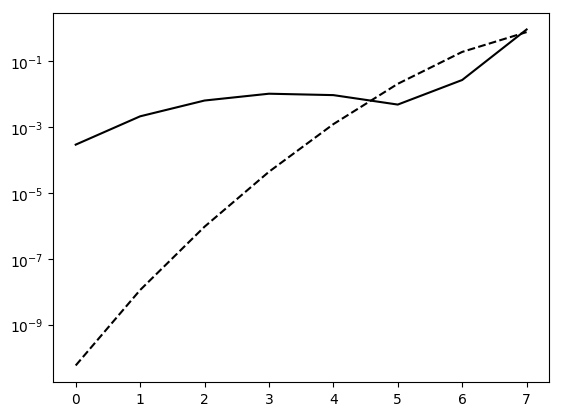

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x152a08e90>

In [199]:
plot(pkis_naive,"--k")
semilogy(pkis,"-k")

In [162]:
GraphClustering.binomial_pdf(10,11,0.5)

0.0

In [163]:
function get_p_k_i_naive(C,ms::EdgeCounts,central_infected::Bool)
    return GraphClustering.binomial_pdf.(ms.k,collect(0:ms.k),get_z_a(ms,central_infected))
end

function get_p_k_i_single(C,ms::EdgeCounts,central_infected::Bool)
    pkis = zeros(k+1)
    z_a = get_z_a(ms,central_infected)
    z_a_b_inf = get_z_a_b_mean(C,ms,central_infected,true)
    z_a_b_sus = get_z_a_b_mean(C,ms,central_infected,false)
    I_probs = [z_a,1-z_a]
    k_prime_probs_inf = GraphClustering.binomial_pdf.(k-1,0:k-1,z_a_b_inf)
    k_prime_probs_sus = GraphClustering.binomial_pdf.(k-1,0:k-1,z_a_b_sus)
    for i = 0:k
        if i > 0
            pkis[i+1] += z_a*GraphClustering.binomial_pdf.(k-1,i-1,z_a_b_inf)
        end
        if i < k
            pkis[i+1] += (1-z_a)*GraphClustering.binomial_pdf.(k-1,i,z_a_b_sus)
        end
    end
    pkis
end
        

function get_p_k_i_global(C,ms::EdgeCounts,central_infected::Bool)
    return get_p_k_i_single(C,ms,central_infected)
    k = ms.k
    pkis = zeros(k+1)
    z = get_z_a(ms,central_infected)
    pii = get_edge_fraction(ms,true,true)
    pis = get_edge_fraction(ms,true,false)
    pss = get_edge_fraction(ms,false,false)
    for ki = 0:k
        fac = GraphClustering.binomial_pdf(k,ki,z)*get_multinomial_community_factor(C,k,ki,pis,pii,pss)
        pkis[ki+1] = fac
    end
    return pkis/sum(pkis)
end

function get_multinomial_community_factor(C,k,ki,pis,pii,pss)
    ks = k-ki
    ntot = C*k*(k-1)/2
    nis = C*ki*ks
    nii = C*ki*(ki-1)/2
    nss = C*ks*(ks-1)/2
    ret = cont_factorial(ntot)/(cont_factorial(nii)*cont_factorial(nis)*cont_factorial(nss))
    ret *= pis^nis*pii^nii*pss^nss
    return ret
end

function cont_factorial(x)
    ret = gamma(1+x)
    return ret
end

function get_edge_fraction(ms::EdgeCounts,first_infected::Bool,second_infected::Bool)
    count = 0
    if first_infected && second_infected
        count = ms.mii
    elseif !first_infected && !second_infected
        count = ms.mss
    else
        count = 2*ms.mis
    end
    return count/(ms.m)
end

function get_p_k_i_posterior(ms::EdgeCounts,pkis::Array{Float64,1},central_infected::Bool,alpha,beta)
    k = ms.k
    pkis_post = zeros(k+1)
    k = ms.k
    update_fn = central_infected ? GraphClustering.p_i_to_s : GraphClustering.p_s_to_i
    for ki = 0:k 
        y = ki/k
        pkis_post[ki+1] = pkis[ki+1]*update_fn(y,y^2,alpha,beta)
    end
    pkis_post
end


function get_y_y_sq(ms::EdgeCounts,pkis::Array{Float64,1})
    k = ms.k
    y = get_mean(pkis)/k
    y_sq = get_var(pkis)/k^2
    return y,y_sq 
end



function get_delta_mis_mii_gillespie_global(ms::EdgeCounts,C::Float64,N::Int,alpha,beta)
    k = ms.k
    pkis_post_vec = []
    rates = Float64[]
    options_vec = [false,true]
    
    for central_infected in [false,true]
        pkis = get_p_k_i_global(C,ms,central_infected)
        pkis_post = get_p_k_i_posterior(ms,pkis,central_infected,alpha,beta)
        y,y_sq = get_y_y_sq(ms,pkis)
        transition_fn = central_infected ? GraphClustering.p_i_to_s : GraphClustering.p_s_to_i
        node_count = GraphClustering.get_node_count(ms,central_infected)
        println(pkis)
        println(get_mean(pkis))
        rate = node_count*transition_fn(y,y_sq,alpha,beta)
        push!(rates,rate)
        push!(pkis_post_vec,pkis_post)
    end
    change_idx,t = GraphClustering.pick_update_and_time(rates)
    central_infected = options_vec[change_idx]
    ki = get_sample(pkis_post_vec[change_idx])
    ks = k - ki


    delta_mii,delta_mis = 0,0
    delta_mii_loc = 2*ki
    delta_mis_loc = ki - ks

    if central_infected
        delta_mii -= delta_mii_loc
        delta_mis += delta_mis_loc
    else
        delta_mii += delta_mii_loc
        delta_mis -= delta_mis_loc
    end
    return delta_mis,delta_mii
end

function get_mean(dist)
    tot = 0
    for i = 0:length(dist)-1
        tot += i*dist[i+1]
    end
    tot
end

function get_var(dist)
    tot = 0
    for i = 0:length(dist)-1
        tot += i^2*dist[i+1]
    end
    tot
end

function get_sample(dist)
    return sample(0:length(dist)-1,Weights(dist))
end

get_sample (generic function with 1 method)

In [121]:
for i = 1:3
    x1,x2 = get_delta_mis_mii_gillespie_global(ms,C,N,alpha,beta)
    println(x1 + x2)
end

[0.982569, 0.0173187, 0.000112004, 3.71621e-7, 6.8861e-10, 6.86527e-13, 2.95489e-16, 9.70532e-21]
0.01754381230242915
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
7
[0.982569, 0.0173187, 0.000112004, 3.71621e-7, 6.8861e-10, 6.86527e-13, 2.95489e-16, 9.70532e-21]
0.01754381230242915
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
7
[0.982569, 0.0173187, 0.000112004, 3.71621e-7, 6.8861e-10, 6.86527e-13, 2.95489e-16, 9.70532e-21]
0.01754381230242915
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
7


In [124]:
get_p_k_i_global(0.00, ms, central_infected)

8-element Array{Float64,1}:
 0.982587   
 0.0172817  
 0.000130264
 5.45494e-7 
 1.37059e-9 
 2.06621e-12
 1.7305e-15 
 6.2114e-19 

In [125]:
get_p_k_i_naive(0.5, ms, central_infected)

8-element Array{Float64,1}:
 0.982587   
 0.0172817  
 0.000130264
 5.45494e-7 
 1.37059e-9 
 2.06621e-12
 1.7305e-15 
 6.2114e-19 